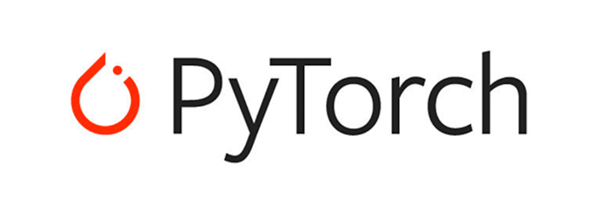

After reading this notebook you'll know:
* the basics of PyTorch with explanations
* how to build up a simple network in PyTorch for PetFinder challenge

I used these great resources for my notebook: [PyTorch tutorials](https://pytorch.org/tutorials/), [notebook](https://www.kaggle.com/debarshichanda/pytorch-w-b-pawpularity-training), [towardsdatascience article](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e).

## Libraries

In [ ]:
import sys
sys.path.append("../input/timmmaster/")

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import random
import timm
import time
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold

## Config

In [ ]:
class CONFIG:
    seed = 0
    image_size = 256
    model_name = "efficientnet_b0"
    num_epochs = 10
    batch_size = 64
    learning_rate = 1e-4
    weight_decay = 1e-6
    n_splits = 5

## Setting the seed

Setting the seed for the entire notebook is important so that we can reproduce the results any time. It is very useful for experimentation because we can test whether a new tweak in the modelling really helped without randomness in our metrics.
https://www.kaggle.com/debarshichanda/pytorch-w-b-pawpularity-training

In [ ]:
def set_seed(seed):
    '''
    Sets the seed of the entire notebook for reproducibility.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)

## Datasets

In [ ]:
INPUT_DIR = "../input/petfinder-pawpularity-score/"
TRAIN_DIR = INPUT_DIR + "train/"
TEST_DIR = INPUT_DIR + "test/"
train_labels = pd.read_csv(INPUT_DIR + "train.csv")
test_labels = pd.read_csv(INPUT_DIR + "test.csv")
sample_submission = pd.read_csv(INPUT_DIR + "sample_submission.csv")
train_labels.shape

In [ ]:
train_labels.head()

## Create folds

Here, we add the fold indices to the train metadata. These indices will be used during K-fold CV to create the training and validation dataloaders.

In [ ]:
def create_folds(df, n_splits, seed):
    '''
    Assigns fold index to each image in df according to K-fold CV.
    '''
    df['fold'] = -1
    kf = KFold(n_splits = n_splits, shuffle=True, random_state=seed)
    for fold_idx, (trn_idx, val_idx) in enumerate(kf.split(df)):
        df.loc[val_idx,'fold'] = fold_idx
    return df

In [ ]:
train_labels = create_folds(train_labels, CONFIG.n_splits, CONFIG.seed)
train_labels.head()

## Dataset class

In PyTorch, a **dataset** is represented by a regular **Python class** that inherits from the **Dataset** class. You can think of it as a kind of a Python **list of tuples**, each tuple corresponding to one point **(features, label)**. The most fundamental methods that need to be implemented are:
* `__init__`: it takes whatever arguments needed to build a list of tuples - in this case, the metadata as a dataframe ('labels_df'), the path to the images ('img_dir') and 'transform' argument that will be used to perform augmentations on the loaded images
* `__getitem__`: function loads and returns a sample from the dataset at the given index 'idx'. Based on the index, it identifies the image’s location on disk, converts that to a tensor using 'cv2.imread', retrieves the corresponding label from 'labels_df' dataframe, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.
* `__len__`: simply returns the size of the dataset, so whenever it is sampled, its indexing is limited to this size

In [ ]:
class PetfinderDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None):
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return(len(self.labels_df))
    
    def __getitem__(self, idx):
        img_path = self.img_dir + self.labels_df.loc[idx,'Id'] + ".jpg"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels_df.loc[idx,'Pawpularity']
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

## Augmentations

As we use pretrained weights that were obtained on ImageNet, it is good practice to **normalize the images** using the mean and standard deviation of ImageNet images' RGB channels.

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG.image_size, CONFIG.image_size),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG.image_size, CONFIG.image_size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

## Model

In PyTorch, a model is represented by a regular **Python class** that inherits from the [**nn.Module**](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) class. The most fundamental methods needed to be implemented are: 
* `__init__(self)`: it defines the neural network layers. As we use transfer learning, we load  a pretrained architecture from the 'timm' package. These models are pretrained on [ImageNet](https://www.image-net.org/update-mar-11-2021.php) and they make predictions on 1000 classes, so we need to modify the classifier head to output a single prediction for the regression task.
* `forward(self, x)`: implements the operations on the input tensor (image) `x`, i.e. the forward pass

In [ ]:
# check whether GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

In [ ]:
class PetfinderModel(nn.Module):
    def __init__(self):
        super(PetfinderModel, self).__init__()
        self.model = timm.create_model(CONFIG.model_name, pretrained=True, in_chans=3)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, out_features=1)
        
    def forward(self, x):
        x = self.model(x)
        return x

## Loss function

In [ ]:
def loss_fn(y, yhat):
    criterion = nn.MSELoss(reduction='mean')
    return torch.sqrt(criterion(y.view(-1), yhat.view(-1)))

## Training function

To perform a training step, we need four inputs in this simple setup: a train loader, a model, a loss function and an optimizer. First, we need to set the model to training mode using `model.train()`. This is important because there are methods like **Dropout** which have **distinct behaviors in training and evaluation** phases .

Then, we iterate over the train loader which loads a mini-batch of (image, label) pairs in each iteration. As the data is on the CPU, we need to send the loaded mini-batch to the GPU with the `.to()` method. Next, we perform the forward pass, calculate the loss based on the predictions and **compute the gradients** using the `loss.backward()` method. We **update the parameters** of the network using the gradients by `optimizer.step()`. As the gradients are accumulated, we need to **zero** them after having updated the parameters. This is done by `optimizer.zero_grad()`.

Here, `loss` is a Tensor stored on the GPU, so we cannot use `numpy` to calculate the average loss on the given mini-batch. Thus, we have a class `AverageCalc` that calculates the running average while we iterate over the mini-batch (code is from [this notebook](https://www.kaggle.com/yasufuminakama/petfinder-efficientnet-b0-starter-training)).

In [ ]:
class AverageCalc(object):
    '''
    Calculates and stores the average and current value.
    Used to update the loss.
    '''
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, value, size=1):
        self.value = value
        self.sum += value * size
        self.count += size
        self.avg = self.sum/self.count  


def train_one_epoch(train_loader, model, loss_fn, optimizer):
    '''
    Performs training for one epoch.
    '''
    current_loss = AverageCalc()
    # set model to train mode
    model.train()
    # iterate over the train_loader
    for img_batch, y_batch in train_loader:
        # move the mini-batch to the GPU
        img_batch = img_batch.to(device, dtype=torch.float)
        y_batch = y_batch.to(device, dtype=torch.float)
        batch_size = y_batch.size(0)
        
        # make predictions, forward pass
        yhat_batch = model(img_batch)
        
        # compute the loss
        loss = loss_fn(y_batch, yhat_batch)
        
        # compute the gradients
        loss.backward()
        # update loss
        current_loss.update(loss.item(), batch_size)
        
        # update parameters
        optimizer.step()
        # zero gradients
        optimizer.zero_grad()
        
    return current_loss.avg

## Validation function

To **disable gradient computations** in validation, it is good practice to wrap the validation loop with `torch.no_grad` context manager. We need to set the model to evaluation mode by `model.eval()`.

In [ ]:
# context-manager to disable gradient computation for inference
@torch.no_grad()
def valid_one_epoch(valid_loader, model, loss_fn, optimizer):
    '''
    Performs inference for one epoch.
    '''
    current_loss = AverageCalc()
    # set model to evaluation mode
    model.eval()
    # iterate over the valid_loader
    for img_batch, y_batch in valid_loader:
        # move the mini-batch to the GPU
        img_batch = img_batch.to(device, dtype=torch.float)
        y_batch = y_batch.to(device, dtype=torch.float)
        batch_size = y_batch.size(0)
        
        # make predictions
        yhat_batch = model(img_batch)
        
        # compute the loss
        loss = loss_fn(y_batch, yhat_batch)
        # update loss
        current_loss.update(loss.item(), batch_size)
    
    return current_loss.avg

## Create data loaders for CV

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in mini-batches, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval. This is what `DataLoader` is good for!

We perform different augmentations on training and validation images, so I wrote a function that creates the dataloaders for training and validation for a single fold in K-fold CV.

In [ ]:
def create_loaders_one_fold(df: pd.DataFrame, img_dir: str, fold: int):
    '''
    Creates training and validation data loaders for one fold in K-fold CV.
    '''
    df_train = df[df['fold'] != fold].reset_index(drop=True)
    df_valid = df[df['fold'] == fold].reset_index(drop=True)
    
    # create Dataset objects
    train_dataset = PetfinderDataset(df_train, img_dir, transform=data_transforms['train'])
    valid_dataset = PetfinderDataset(df_valid, img_dir, transform=data_transforms['valid'])
    
    # create Dataloader objects
    train_loader = DataLoader(train_dataset, CONFIG.batch_size, num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, CONFIG.batch_size, num_workers=2, shuffle=False, pin_memory=True, drop_last=False)
    
    return train_loader, valid_loader

## Run training

Training and validation loss are saved to `history` dictionary that will be used to plot them over the epochs. Current values of the **learnable parameters** are stored in `model.state_dict()` Python dictionary. Once the validation loss decreases, this dictionary is **saved to the disk** by `torch.save(model.state_dict())`.

As data is now made of GPU tensors, we need to **move the model** there as well by `model.to(device)`.

In [ ]:
def plot_history(history: dict):
    '''
    Plots the training and validation loss over the epochs.
    '''
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(np.arange(1, CONFIG.num_epochs+1), history['train_loss'], color='orange', marker='o', linestyle='solid', label='Train RMSE')
    ax.plot(np.arange(1, CONFIG.num_epochs+1), history['valid_loss'], color='blue', marker='o', linestyle='solid', label='Valid RMSE')
    ax.set_xlabel('Epoch'); ax.set_ylabel('RMSE')
    plt.legend(loc='upper left')
    xdist = ax.get_xlim()[1] - ax.get_xlim()[0]; ydist = ax.get_ylim()[1] - ax.get_ylim()[0]
    x_min_loss = np.argmin(history['valid_loss'])+1; y_min_loss = np.min(history['valid_loss'])
    ax.scatter(x_min_loss, y_min_loss, s=200, color='blue')
    ax.text(x_min_loss-0.03*xdist, y_min_loss-0.13*ydist, 'min rmse\n%.2f'%y_min_loss, size=14)


def run_training_one_fold(model, optimizer, loss_fn, num_epochs, fold):
    '''
    Runs training and validation for one fold of K-fold CV.
    '''
    print(f"Fold {fold}:")
    start_time = time.time()
    train_loader, valid_loader = create_loaders_one_fold(train_labels, TRAIN_DIR, fold)
    
    history = {'train_loss': [], 'valid_loss': []}
    # set best validation loss to infinity
    best_valid_loss = np.inf
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        valid_loss = valid_one_epoch(valid_loader, model, loss_fn, optimizer)
        
        # store the losses
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        
        # save the model if validation loss decreases
        if valid_loss < best_valid_loss:
            print(f"Validation loss decreased: {best_valid_loss} --> {valid_loss}")
            best_valid_loss = valid_loss
            torch.save(model.state_dict(),
                       f"{CONFIG.model_name}_fold{fold}_rmse{best_valid_loss:.4f}.pth")
        
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    return history

In [ ]:
model = PetfinderModel()
# move the model to the GPU
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate, weight_decay=CONFIG.weight_decay)
for fold in range(CONFIG.n_splits):
    history = run_training_one_fold(model, optimizer, loss_fn, CONFIG.num_epochs, fold)
    plot_history(history)
    break